In [1]:
import pandas as pd
import seaborn as sn

import tensorflow as tf
import tensorflow_hub as hub
from keras import Input
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [2]:
## Check for CUDA GPU (skip if no CUDA GPU) ##

print(tf.test.is_built_with_cuda()) # Should be True
print(tf.config.list_physical_devices('GPU')) # Should not be empty

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
### DEEP LEARNING ###
from helper import *

## EXTRACTING X AND Y MATRICES. READ HELPER FOR FUNCTION INFO ##
dh = data_handle()

In [4]:
classes = (3,5)
img_size = 128

X, y = dh.featurize(resize=img_size, n=2000, include=classes) 
# 5000 images since only two classes - this takes 30ish minutes but thankfully doesn't eat up memory

num_classes = len(classes)

In [5]:
## Preprocess images ##
lb = preprocessing.LabelBinarizer()

range_ = np.array(list(set(y)))
out = lb.fit(range_)
y_binary = out.transform(y.astype(int))

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.20, random_state=42)

In [40]:
## Convert to RGB (copy greyscale values 3 times) ##

X_train_rgb = np.empty((len(X_train), img_size, img_size, 3))
X_test_rgb = np.empty((len(X_test), img_size, img_size, 3))

for i in range(len(X_train)):
    X_train_rgb[i] = cv2.cvtColor(X_train[i] * 255, cv2.COLOR_GRAY2RGB).reshape(-1, img_size, img_size, 3)
for i in range(len(X_test)):
    X_test_rgb[i] = cv2.cvtColor(X_test[i] * 255, cv2.COLOR_GRAY2RGB).reshape(-1, img_size, img_size, 3)
    
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_b_rgb, y_train_b))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_b_rgb, y_test_b))

In [8]:
def dense_block(units, dropout_rate):
    block = Sequential([
        Dense(units, activation='relu'),
#         BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True, shear_range=0.2, zoom_range=0.2, rotation_range=20)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_rgb, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test_rgb, y_test, batch_size=32)

In [9]:
## AlexNet variant with adjusted image size ##

alexnet = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_size,img_size,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


alexnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',  \
                                                                      tf.keras.metrics.Precision(name='precision'), \
                                                                       tf.keras.metrics.Recall(name='recall')])
# alexnet.summary()

In [10]:
checkpoint = ModelCheckpoint(filepath='best_weights_alexnet.hdf5', save_best_only=True, save_weights_only=True)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

alexnet.fit(train_generator,
           epochs=20, batch_size=32, validation_data=test_generator, 
           callbacks=[checkpoint, early_stop])

Epoch 1/20
100/100 [==============================] - 16s 157ms/step - loss: 1.2825 - accuracy: 0.5419 - precision: 0.5480 - recall: 0.5609 - val_loss: 0.7067 - val_accuracy: 0.4950 - val_precision: 0.4685 - val_recall: 0.5360
Epoch 2/20
100/100 [==============================] - 14s 143ms/step - loss: 0.6886 - accuracy: 0.5809 - precision: 0.5842 - recall: 0.6073 - val_loss: 0.6816 - val_accuracy: 0.5942 - val_precision: 0.6494 - val_recall: 0.3013
Epoch 3/20
100/100 [==============================] - 14s 140ms/step - loss: 0.6791 - accuracy: 0.5815 - precision: 0.5852 - recall: 0.6054 - val_loss: 0.6584 - val_accuracy: 0.6030 - val_precision: 0.6453 - val_recall: 0.3493
Epoch 4/20
100/100 [==============================] - 14s 141ms/step - loss: 0.6721 - accuracy: 0.5988 - precision: 0.6079 - recall: 0.5925 - val_loss: 0.6524 - val_accuracy: 0.6193 - val_precision: 0.5923 - val_recall: 0.6160
Epoch 5/20
100/100 [==============================] - 17s 170ms/step - loss: 0.6714 - accura

In [11]:
results = alexnet.evaluate(X_test_rgb, y_test)

25/25 [==============================] - 0s 15ms/step - loss: 0.6465 - accuracy: 0.6332 - precision: 0.7219 - recall: 0.3600


In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip=True, shear_range=0.2, zoom_range=0.2, rotation_range=20, \
                                   preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow(X_train_rgb, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test_rgb, y_test, batch_size=32)

In [12]:
## VGG19 Setup ##

from keras.applications.vgg19 import VGG19

vgg = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)), pooling='avg')
# Freeze all layers - classifier is tacked on

for layer in vgg.layers:
    layer.trainable = False

flat1 = Flatten()(vgg.layers[-1].output)
block1 = dense_block(1028, 0.2)(flat1)
# block2 = dense_block(512, 0.5)(block1)
# block3 = dense_block(64, 0.2)(block2)
# drop1 = Dropout(0.3)(resnet.layers[-1].output)
output = Dense(1, activation='sigmoid')(block1)
vgg = Model(inputs=vgg.inputs, outputs=output)

vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',  \
                                                                      tf.keras.metrics.Precision(name='precision'), \
                                                                       tf.keras.metrics.Recall(name='recall')])

# resnet.summary()

In [13]:
checkpoint = ModelCheckpoint(filepath='best_weights_vgg19.hdf5', save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

vgg_history = vgg.fit(train_generator,
                      epochs=30, batch_size=32, validation_data=test_generator, 
                      callbacks=[checkpoint, early_stop])

Epoch 1/30
100/100 [==============================] - 20s 204ms/step - loss: 1.4205 - accuracy: 0.5859 - precision: 0.5926 - recall: 0.5941 - val_loss: 0.8193 - val_accuracy: 0.5947 - val_precision: 0.5501 - val_recall: 0.7487
Epoch 2/30
100/100 [==============================] - 16s 163ms/step - loss: 0.7626 - accuracy: 0.6070 - precision: 0.6139 - recall: 0.6120 - val_loss: 0.9414 - val_accuracy: 0.5332 - val_precision: 0.5014 - val_recall: 0.9679
Epoch 3/30
100/100 [==============================] - 18s 185ms/step - loss: 0.6602 - accuracy: 0.6412 - precision: 0.6443 - recall: 0.6570 - val_loss: 0.7472 - val_accuracy: 0.5910 - val_precision: 0.5443 - val_recall: 0.7888
Epoch 4/30
100/100 [==============================] - 17s 166ms/step - loss: 0.6340 - accuracy: 0.6556 - precision: 0.6637 - recall: 0.6539 - val_loss: 0.6463 - val_accuracy: 0.6324 - val_precision: 0.6036 - val_recall: 0.6310
Epoch 5/30
100/100 [==============================] - 17s 171ms/step - loss: 0.6191 - accura

In [14]:
X_test_rgb = tf.keras.applications.vgg19.preprocess_input(X_test_rgb)
results = vgg.evaluate(X_test_rgb, y_test)

25/25 [==============================] - 3s 120ms/step - loss: 0.6463 - accuracy: 0.6324 - precision: 0.6036 - recall: 0.6310


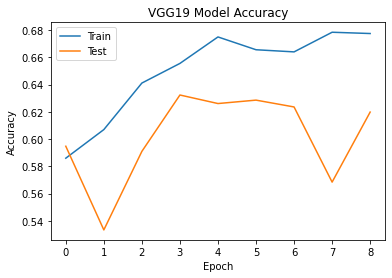

In [15]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('VGG19 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

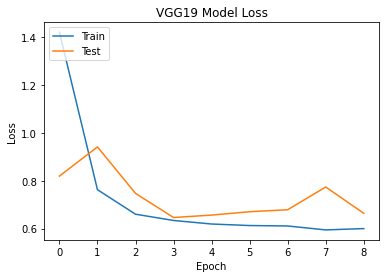

In [16]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('VGG19 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

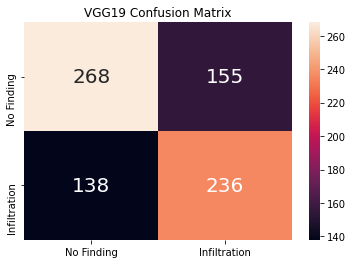

In [17]:
y_pred = np.round(vgg.predict(X_test_rgb))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred) # No argmax for binary

df_cm = pd.DataFrame(confusion_matrix, range(num_classes), range(num_classes))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}, fmt='g', \
           xticklabels=["No Finding", "Infiltration"], yticklabels=["No Finding", "Infiltration"])
plt.title("VGG19 Confusion Matrix")

plt.show()

In [19]:
## Preprocess input for ResNet50 ##

# This actually overwrites X_train and X_test!
# This is bad, because each model uses its own preprocess_input
# and each returns different results. No good workaround
# but to rerun the cell that generates X_train_rgb/X_test_rgb
# (really I should have written functions for all of this...)

train_datagen = ImageDataGenerator(horizontal_flip=True, shear_range=0.2, zoom_range=0.2, rotation_range=20, \
                                   preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow(X_train_rgb, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test_rgb, y_test, batch_size=32)

245.375 0.0 124.63908813989178


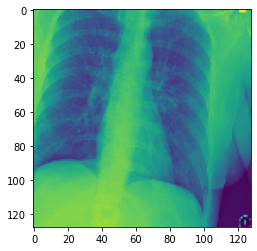

In [20]:
## Just checking that it works (should normalize with mean ~0) ##

image = X_train_rgb[0,:,:,0]
print(np.max(image), np.min(image), np.mean(image))
plt.imshow(image)

In [21]:
## Resnet50 Setup ##

from keras.applications.resnet import ResNet50

resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)), pooling='avg')
# Freeze all layers - classifier is tacked on

for layer in resnet.layers:
    layer.trainable = False

flat1 = Flatten()(resnet.layers[-1].output)
block1 = dense_block(1028, 0.2)(flat1)
# block2 = dense_block(512, 0.5)(block1)
# block3 = dense_block(64, 0.2)(block2)
# drop1 = Dropout(0.3)(resnet.layers[-1].output)
output = Dense(1, activation='sigmoid')(block1)
resnet = Model(inputs=resnet.inputs, outputs=output)

resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',  \
                                                                      tf.keras.metrics.Precision(name='precision'), \
                                                                       tf.keras.metrics.Recall(name='recall')])

# resnet.summary()

In [22]:
## ResNet50 Train ##

checkpoint = ModelCheckpoint(filepath='best_weights_resnet.hdf5', save_best_only=True, save_weights_only=True)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss' factor=0.1, patience=2)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

resnet_history = resnet.fit(train_generator, epochs=30, 
                 batch_size=32, validation_data=test_generator,
                 callbacks=[checkpoint, early_stop])

Epoch 1/30
100/100 [==============================] - 19s 192ms/step - loss: 1.1575 - accuracy: 0.5997 - precision: 0.6059 - recall: 0.6089 - val_loss: 0.6394 - val_accuracy: 0.6524 - val_precision: 0.6570 - val_recall: 0.5428
Epoch 2/30
100/100 [==============================] - 16s 159ms/step - loss: 0.6297 - accuracy: 0.6600 - precision: 0.6698 - recall: 0.6533 - val_loss: 0.6436 - val_accuracy: 0.6512 - val_precision: 0.6364 - val_recall: 0.5989
Epoch 3/30
100/100 [==============================] - 16s 163ms/step - loss: 0.6258 - accuracy: 0.6509 - precision: 0.6620 - recall: 0.6403 - val_loss: 0.6461 - val_accuracy: 0.6537 - val_precision: 0.7248 - val_recall: 0.4225
Epoch 4/30
100/100 [==============================] - 16s 164ms/step - loss: 0.6164 - accuracy: 0.6728 - precision: 0.6857 - recall: 0.6582 - val_loss: 0.6262 - val_accuracy: 0.6625 - val_precision: 0.6733 - val_recall: 0.5455
Epoch 5/30
100/100 [==============================] - 16s 157ms/step - loss: 0.6094 - accura

In [23]:
X_test_rgb = tf.keras.applications.resnet.preprocess_input(X_test_rgb)
results = resnet.evaluate(X_test_rgb, y_test)

25/25 [==============================] - 2s 86ms/step - loss: 0.6262 - accuracy: 0.6625 - precision: 0.6733 - recall: 0.5455


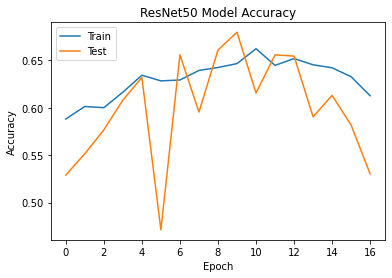

In [19]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

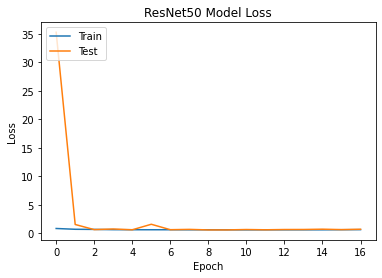

In [20]:
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

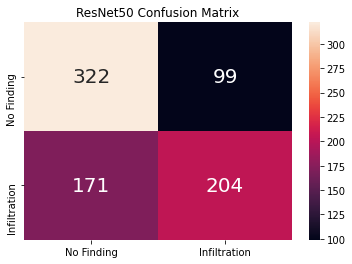

In [21]:
y_pred = np.round(resnet.predict(X_test_rgb))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred) # No argmax for binary

df_cm = pd.DataFrame(confusion_matrix, range(num_classes), range(num_classes))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}, fmt='g', \
           xticklabels=["No Finding", "Infiltration"], yticklabels=["No Finding", "Infiltration"])
plt.title("ResNet50 Confusion Matrix")

plt.show()

In [25]:
## Preprocess input for InceptionV3 ##

train_datagen = ImageDataGenerator(horizontal_flip=True, shear_range=0.2, zoom_range=0.2, rotation_range=20, \
                                   preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_generator = train_datagen.flow(X_train_rgb, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test_rgb, y_test, batch_size=32)

235.671875 0.0 110.84318720187002


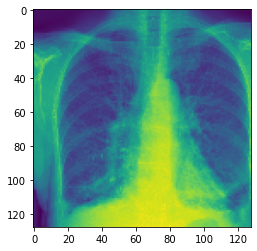

In [25]:
## Just checking that it works (should normalize with mean 0) ##

image = X_train_rgb[0,:,:,0]
print(np.max(image), np.min(image), np.mean(image))
plt.imshow(image)

In [26]:
from keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)), pooling='avg')
# for layer in inception.layers:
#     layer.trainable = False

for layer in inception.layers[:249]:
   layer.trainable = False
for layer in inception.layers[249:]:
   layer.trainable = True


flat1 = Flatten()(inception.layers[-1].output)
block1 = dense_block(1028, 0.2)(flat1)
# block2 = dense_block(512, 0.5)(block1)
# block3 = dense_block(256, 0.2)(block2)
# dense1 = Dense(64, activation='relu')(block3)
# drop1 = Dropout(0.4)(inception.layers[-1].output)
output = Dense(1, activation='sigmoid')(block1)
inception = Model(inputs=inception.inputs, outputs=output)

inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',  \
                                                                      tf.keras.metrics.Precision(name='precision'), \
                                                                       tf.keras.metrics.Recall(name='recall')])

# inception.summary()

In [27]:
checkpoint = ModelCheckpoint(filepath='best_weights_inception.hdf5', save_best_only=True, save_weights_only=True)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=2)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

inception_history = inception.fit(train_generator, epochs=30, 
                 batch_size=32, validation_data=test_generator,
                 callbacks=[checkpoint, early_stop])

Epoch 1/30
100/100 [==============================] - 20s 202ms/step - loss: 0.7827 - accuracy: 0.5966 - precision: 0.6076 - recall: 0.5836 - val_loss: 0.6650 - val_accuracy: 0.6023 - val_precision: 0.5624 - val_recall: 0.6872
Epoch 2/30
100/100 [==============================] - 16s 158ms/step - loss: 0.6320 - accuracy: 0.6496 - precision: 0.6643 - recall: 0.6286 - val_loss: 0.6558 - val_accuracy: 0.6487 - val_precision: 0.6975 - val_recall: 0.4439
Epoch 3/30
100/100 [==============================] - 15s 150ms/step - loss: 0.6158 - accuracy: 0.6678 - precision: 0.6943 - recall: 0.6194 - val_loss: 0.6950 - val_accuracy: 0.6449 - val_precision: 0.6071 - val_recall: 0.6898
Epoch 4/30
100/100 [==============================] - 17s 167ms/step - loss: 0.6089 - accuracy: 0.6757 - precision: 0.7045 - recall: 0.6237 - val_loss: 0.6445 - val_accuracy: 0.6738 - val_precision: 0.7159 - val_recall: 0.5053
Epoch 5/30
100/100 [==============================] - 15s 152ms/step - loss: 0.5973 - accura

In [28]:
X_test_rgb = tf.keras.applications.inception_v3.preprocess_input(X_test_rgb)
results = inception.evaluate(X_test_rgb, y_test)

25/25 [==============================] - 2s 68ms/step - loss: 0.6293 - accuracy: 0.6499 - precision: 0.6480 - recall: 0.5561


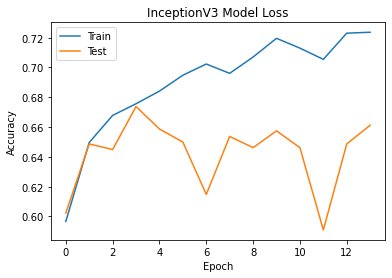

In [29]:
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('InceptionV3 Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

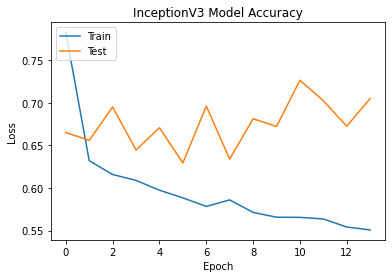

In [30]:
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('InceptionV3 Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

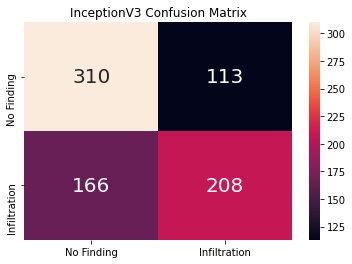

In [31]:
y_pred = np.round(inception.predict(X_test_rgb)) # np.round for binary

confusion_matrix = metrics.confusion_matrix(y_test, y_pred) # No argmax for binary

df_cm = pd.DataFrame(confusion_matrix, range(num_classes), range(num_classes))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}, fmt='g', \
           xticklabels=["No Finding", "Infiltration"], yticklabels=["No Finding", "Infiltration"])
plt.title("InceptionV3 Confusion Matrix")

plt.show()

In [42]:
train_datagen = ImageDataGenerator(horizontal_flip=True, shear_range=0.2, zoom_range=0.2, rotation_range=20, \
                                   preprocessing_function=tf.keras.applications.densenet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

train_generator = train_datagen.flow(X_train_rgb, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test_rgb, y_test, batch_size=32)

235.671875 0.0 110.84318720187002


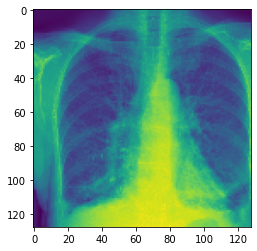

In [43]:
## Just checking that it works (should normalize with mean ~0) ##

image = X_train_rgb[0,:,:,0]
print(np.max(image), np.min(image), np.mean(image))
plt.imshow(image)

In [34]:
from keras.applications.densenet import DenseNet121

densenet = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)), \
                       pooling ='avg') 

for layer in densenet.layers:
    layer.trainable = False

flat1 = Flatten()(densenet.layers[-1].output)
block1 = dense_block(1028, 0.2)(flat1)
# block2 = dense_block(512, 0.5)(block1)
# drop1 = Dropout(0.4)(densenet.layers[-1].output)
output = Dense(1, activation='sigmoid')(block1)
densenet = Model(inputs=densenet.inputs, outputs=output)

densenet.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy',  \
                                                                      tf.keras.metrics.Precision(name='precision'), \
                                                                       tf.keras.metrics.Recall(name='recall')])

# densenet.summary()

In [35]:
checkpoint = ModelCheckpoint(filepath='best_weights_densenet.hdf5', save_best_only=True, save_weights_only=True)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)


densenet_history = densenet.fit(train_generator, epochs=30, 
                                batch_size=32, validation_data=test_generator,
                                callbacks=[checkpoint, early_stop])

Epoch 1/30
100/100 [==============================] - 21s 208ms/step - loss: 0.8343 - accuracy: 0.6010 - precision: 0.6079 - recall: 0.6064 - val_loss: 0.6913 - val_accuracy: 0.5872 - val_precision: 0.5404 - val_recall: 0.8048
Epoch 2/30
100/100 [==============================] - 16s 165ms/step - loss: 0.6687 - accuracy: 0.6239 - precision: 0.6265 - recall: 0.6447 - val_loss: 0.6679 - val_accuracy: 0.5922 - val_precision: 0.5455 - val_recall: 0.7861
Epoch 3/30
100/100 [==============================] - 15s 152ms/step - loss: 0.6447 - accuracy: 0.6424 - precision: 0.6519 - recall: 0.6366 - val_loss: 0.6986 - val_accuracy: 0.5709 - val_precision: 0.5276 - val_recall: 0.8182
Epoch 4/30
100/100 [==============================] - 16s 159ms/step - loss: 0.6200 - accuracy: 0.6619 - precision: 0.6704 - recall: 0.6589 - val_loss: 0.6452 - val_accuracy: 0.6286 - val_precision: 0.6083 - val_recall: 0.5856
Epoch 5/30
100/100 [==============================] - 16s 157ms/step - loss: 0.6209 - accura

In [36]:
X_test_rgb = tf.keras.applications.densenet.preprocess_input(X_test_rgb)
results = densenet.evaluate(X_test_rgb, y_test)

25/25 [==============================] - 3s 108ms/step - loss: 0.6721 - accuracy: 0.6311 - precision: 0.5922 - recall: 0.6872


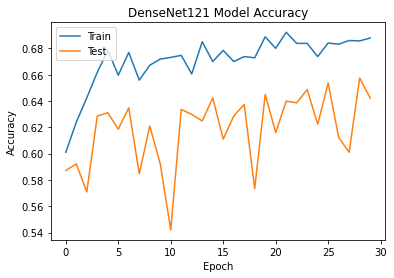

In [37]:
plt.plot(densenet_history.history['accuracy'])
plt.plot(densenet_history.history['val_accuracy'])
plt.title('DenseNet121 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

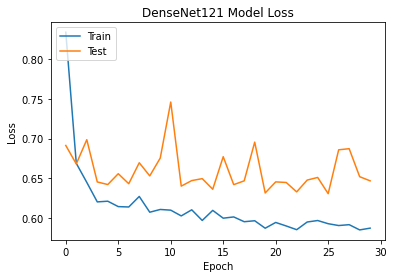

In [38]:
plt.plot(densenet_history.history['loss'])
plt.plot(densenet_history.history['val_loss'])
plt.title('DenseNet121 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

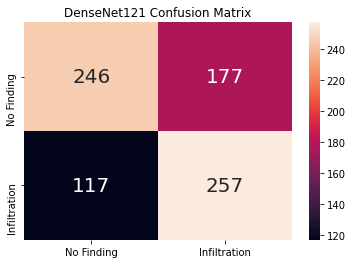

In [39]:
y_pred = np.round(densenet.predict(X_test_rgb)) # np.round for binary

confusion_matrix = metrics.confusion_matrix(y_test, y_pred) # No argmax for binary

df_cm = pd.DataFrame(confusion_matrix, range(num_classes), range(num_classes))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}, fmt='g', \
           xticklabels=["No Finding", "Infiltration"], yticklabels=["No Finding", "Infiltration"])
plt.title("DenseNet121 Confusion Matrix")

plt.show()

In [41]:
train_datagen = ImageDataGenerator(horizontal_flip=True, shear_range=0.2, zoom_range=0.2, rotation_range=20, \
                                   preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

train_generator = train_datagen.flow(X_train_rgb, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test_rgb, y_test, batch_size=32)

In [43]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)), \
                       pooling ='avg') 

for layer in inception_resnet.layers:
    layer.trainable = False

# flat1 = Flatten()(inception_resnet.layers[-1].output)
# block1 = dense_block(1028, 0.2)(flat1)
# block2 = dense_block(512, 0.5)(block1)
# drop1 = Dropout(0.4)(inception_resnet.layers[-1].output)
output = Dense(1, activation='sigmoid')(inception_resnet.layers[-1].output)
inception_resnet = Model(inputs=inception_resnet.inputs, outputs=output)

inception_resnet.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy',  \
                                                                      tf.keras.metrics.Precision(name='precision'), \
                                                                       tf.keras.metrics.Recall(name='recall')])

# inception_resnet.summary()

In [44]:
checkpoint = ModelCheckpoint(filepath='best_weights_inception_resnet.hdf5', save_best_only=True, save_weights_only=True)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)


inception_resnet_history = inception_resnet.fit(train_generator, epochs=30, 
                                batch_size=32, validation_data=test_generator,
                                callbacks=[checkpoint, early_stop])

Epoch 1/30
100/100 [==============================] - 24s 244ms/step - loss: 0.7857 - accuracy: 0.5593 - precision: 0.5664 - recall: 0.5682 - val_loss: 0.7055 - val_accuracy: 0.5822 - val_precision: 0.5476 - val_recall: 0.6310
Epoch 2/30
100/100 [==============================] - 21s 205ms/step - loss: 0.6768 - accuracy: 0.6129 - precision: 0.6186 - recall: 0.6225 - val_loss: 0.6985 - val_accuracy: 0.5972 - val_precision: 0.6031 - val_recall: 0.4144
Epoch 3/30
100/100 [==============================] - 19s 194ms/step - loss: 0.6834 - accuracy: 0.6066 - precision: 0.6145 - recall: 0.6076 - val_loss: 0.7721 - val_accuracy: 0.5546 - val_precision: 0.5146 - val_recall: 0.8957
Epoch 4/30
100/100 [==============================] - 23s 227ms/step - loss: 0.6588 - accuracy: 0.6324 - precision: 0.6378 - recall: 0.6410 - val_loss: 0.6965 - val_accuracy: 0.5947 - val_precision: 0.5486 - val_recall: 0.7701
Epoch 5/30
100/100 [==============================] - 26s 260ms/step - loss: 0.6579 - accura

In [45]:
X_test_rgb = tf.keras.applications.inception_resnet_v2.preprocess_input(X_test_rgb)
results = inception_resnet.evaluate(X_test_rgb, y_test)

25/25 [==============================] - 5s 198ms/step - loss: 0.6606 - accuracy: 0.6110 - precision: 0.5860 - recall: 0.5829


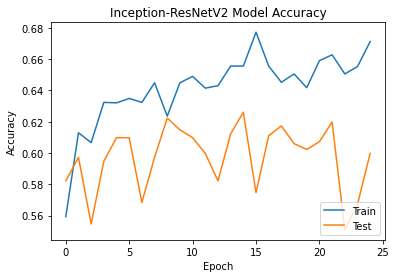

In [46]:
plt.plot(inception_resnet_history.history['accuracy'])
plt.plot(inception_resnet_history.history['val_accuracy'])
plt.title('Inception-ResNetV2 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

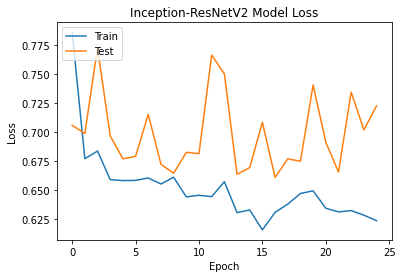

In [47]:
plt.plot(inception_resnet_history.history['loss'])
plt.plot(inception_resnet_history.history['val_loss'])
plt.title('Inception-ResNetV2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

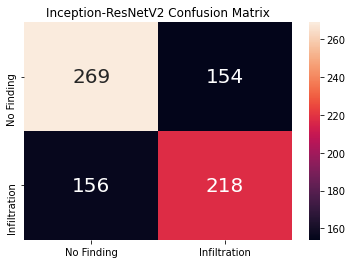

In [48]:
y_pred = np.round(inception_resnet.predict(X_test_rgb)) # np.round for binary

confusion_matrix = metrics.confusion_matrix(y_test, y_pred) # No argmax for binary

df_cm = pd.DataFrame(confusion_matrix, range(num_classes), range(num_classes))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}, fmt='g', \
           xticklabels=["No Finding", "Infiltration"], yticklabels=["No Finding", "Infiltration"])
plt.title("Inception-ResNetV2 Confusion Matrix")

plt.show()